# Ag Analytics-CropDataLayers-Demo

Crop Land Data Layers, also known as CDLs, are published by USDA and provide estimates of historical crops cover.



In [ ]:
import requests
import json
import time
from pandas.io.json import json_normalize
import requests, zipfile, io
import geopandas as gpd
%matplotlib inline
import pandas as pd
%autosave 0

### API Details

####Request URL: https://ag-analytics.azure-api.net/CroplandDataLayers/get[?year][&inputShape][&env:outSR]
        
        
####Request parameters:

***year - ***
Year of desired result.

***inputShape - ***
(ESRI Polygon shape): The shape information for field in esriGeometryPolygon format. Standard open source JavaScript front-end libraries (e.g., Leaflet) can be used to structure the shape

***env:outSR (optional) - ***
Output Spatial Reference. Return features in the specified spatial reference by supplying specific wkid (eg. 4326).

In order to get Ocp-Apim-Subscription-Key, please click on this link https://analytics.ag/Session/SignInToAPIPayment


### Request Parameters

In [ ]:
year=2016
inputShape={"geometryType":"esriGeometryPolygon","features":[{"geometry":{"rings":[[[-89.045774,43.730605],[-89.04577,43.730488],[-89.045722,43.729998],[-89.045789,43.729653],[-89.045661,43.72961],[-89.045635,43.729782],[-89.045644,43.730045],[-89.045653,43.730308],[-89.045651,43.730607],[-89.041228,43.730676],[-89.041171,43.728908],[-89.041111,43.727076],[-89.042892,43.727044],[-89.044665,43.727018],[-89.046178,43.726999],[-89.046237,43.730597],[-89.045774,43.730605]]],"spatialReference":{"wkid":4326}}}]}
env=4326
f="json"
headers={'Ocp-Apim-Subscription-Key': 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'}

###  API Function

In [ ]:
def get_crop_data_layers(year,inputShape,env,headers,f):
    try:
        url = "https://ag-analytics.azure-api.net/CroplandDataLayers/get?year={}&inputShape={}&env:outSR={}&f={}".format(year,inputShape,env,f)
     
        response = (requests.get(url,headers=headers).text)
        print(response)
       
        response_json = json.loads(response)
        time.sleep(0.5)
        return response_json
    
    except Exception as e:
        raise e

### Calling API Function

In [87]:
crop_layer=get_crop_data_layers(year,inputShape,env,headers,f)

{"results":[{"paramName":"output2","dataType":"GPFeatureRecordSetLayer","value":{"displayFieldName":"","geometryType":"esriGeometryPolygon","spatialReference":{"wkid":4326,"latestWkid":4326},"fields":[{"name":"FID","type":"esriFieldTypeOID","alias":"FID"},{"name":"OBJECTID","type":"esriFieldTypeInteger","alias":"OBJECTID"},{"name":"Shape_Leng","type":"esriFieldTypeDouble","alias":"Shape_Leng"},{"name":"FID_08077","type":"esriFieldTypeInteger","alias":"FID_08077"},{"name":"ID","type":"esriFieldTypeInteger","alias":"ID"},{"name":"GRIDCODE","type":"esriFieldTypeInteger","alias":"GRIDCODE"},{"name":"acres","type":"esriFieldTypeSingle","alias":"acres"},{"name":"Shape_Length","type":"esriFieldTypeDouble","alias":"Shape_Length"},{"name":"Shape_Area","type":"esriFieldTypeDouble","alias":"Shape_Area"}],"features":[{"attributes":{"FID":1,"OBJECTID":0,"Shape_Leng":0,"FID_08077":294150,"ID":294151,"GRIDCODE":142,"acres":1.708353,"Shape_Length":0.0049166479059928056,"Shape_Area":7.1753720205756623e

### Displaying Map

In [88]:

#saving the respons eof api in geojson format

file=open('./jsonfiles/cropdatalayers.json','w')
file.write(json.dumps(crop_layer['results'][0]["value"]))
file.close()


# Helper functions for creating shapefiles

def post_converttogeojson(requestbody):
    try:
        url = "https://ogre.adc4gis.com/convert"
     
        response = (requests.post(url,files=requestbody).text)
        
        return response

    except Exception as e:
        raise e
def post_converttoshapefile(requestbody):
    try:
        url = "https://ogre.adc4gis.com/convertJson"
     
        response = (requests.post(url,data=requestbody))
        
        z = zipfile.ZipFile(io.BytesIO(response.content))
        z.extractall("./shapefiles/")
        
        time.sleep(0.5)
        return response
    
    except Exception as e:
        raise e
    

,FID,OBJECTID,Shape_Leng,FID_08077,ID,GRIDCODE,acres,Shape_Le_1,Shape_Area,geometry
0,1,0,0,294150,294151,EvergreenForest,1.708353,0.004917,0.000001,POLYGON ((-108.4445048750999 38.86450936761327...
1,2,0,0,294495,294496,EvergreenForest,0.222394,0.001234,0.000000,POLYGON ((-108.4394186981144 38.86358831524859...
2,3,0,0,294673,294674,Shrubland,0.073975,0.000885,0.000000,POLYGON ((-108.4338013068848 38.86367328949075...
3,4,0,0,294836,294837,EvergreenForest,5.352034,0.010502,0.000002,"POLYGON ((-108.4416505510321 38.8642864112889,..."
4,5,0,0,294837,294838,EvergreenForest,0.222395,0.001234,0.000000,POLYGON ((-108.4395824961352 38.86249191666866...


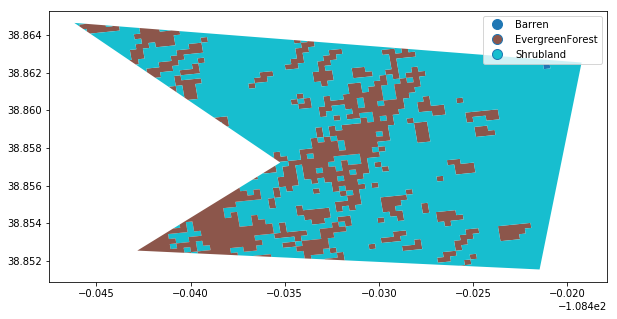

In [89]:
requestbody={'upload':open('./jsonfiles/cropdatalayers.json','rb')}
# Function call to convert json to geojson
cropdata_geojson=post_converttogeojson(requestbody)

requestbody={'json':cropdata_geojson,'skipFailures':"on"}
#function call to creatr shapefile from geojson 
post_converttoshapefile(requestbody)

# Reading a shapefile and displaying the map
gdf = gpd.read_file('./shapefiles/OGRGeoJSON.shp')


grid_code_mappings=pd.read_csv("cropnames_gridcodes_mappings.csv")

grid_code_mappings.set_index('Code',inplace=True)


gdf['GRIDCODE']=gdf['GRIDCODE'].map(grid_code_mappings.to_dict()['CropName'])

gdf.plot(column='GRIDCODE', cmap=None,figsize=(10, 10),legend=True)
gdf.head()

